In [330]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import abc
from collections import namedtuple
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import load_digits

In [347]:
#скопировано с https://github.com/josdas/ML-Algorithms/tree/master/DecisionTree
def entropy(freq: np.array):
    p = freq / freq.sum()
    return -np.sum(p * np.log2(p + 0.1))


def gini(freq: np.array):
    p = freq / freq.sum()
    return 1 - np.sum(p * p)


def variance(y: np.array):
    return np.var(y)


def mad_median(y: np.array):
    return np.abs(y - np.median(y)).sum() / len(y)


CRITERIAS = {
    'gini': gini,
    'entropy': entropy,
    'variance': variance,
    'mad_median': mad_median,
}

In [349]:
#скопировано с https://github.com/josdas/ML-Algorithms/tree/master/DecisionTree

class DecisionTree(BaseEstimator):
    __metaclass__ = abc.ABCMeta

    BestSplitResult = namedtuple('result', 'feature_i threshold score')

    class Vertex:
        __slots__ = ['left', 'right', 'feature_i', 'threshold']

        def __init__(self, left, right, feature_i, threshold):
            self.left = left
            self.right = right
            self.feature_i = feature_i
            self.threshold = threshold

    def __init__(self, max_depth, min_samples_split,
                 criterion, debug=False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.debug = debug

    def _get_predicate(self, X: np.array, feature_i, threshold):
        return X[:, feature_i] < threshold

    def _select_best_split(self, X: np.array, y: np.array):
        best_score = np.inf
        best_i, best_threshold = None, None

        for i in range(self._n_feature):
            feature_list = list(set(sorted(x[i] for x in X)))

            for j in range(len(feature_list) - 1):
                s = (feature_list[j] + feature_list[j + 1]) / 2

                predicate = self._get_predicate(X, i, s)
                l_y, r_y = y[predicate], y[~predicate]

                can_split = len(l_y) >= self.min_samples_split and \
                            len(r_y) >= self.min_samples_split
                if can_split:
                    score = self._fun_criterion(l_y) * len(l_y) + \
                            self._fun_criterion(r_y) * len(r_y)

                    if score < best_score:
                        best_i = i
                        best_threshold = s
                        best_score = score

        return DecisionTree.BestSplitResult(feature_i=best_i,
                                            threshold=best_threshold,
                                            score=best_score)

    def _build_tree(self, X: np.array, y: np.array, depth=0):
        if depth >= self.max_depth:
            if self.debug:
                print('Created a leaf by max_depth')

            return self._leaf_value(y)

        best_i, best_threshold, best_score = self._select_best_split(X, y)

        if best_i is None:
            if self.debug:
                print('Created a leaf by min_samples_split. Score', best_score)

            return self._leaf_value(y)
        else:
            if self.debug:
                print('Created a new vertex')

            predicate = self._get_predicate(X, best_i, best_threshold)
            (l_x, l_y), (r_x, r_y) = (X[predicate], y[predicate]), (X[~predicate], y[~predicate])

            l_vertex = self._build_tree(l_x, l_y, depth + 1)
            r_vertex = self._build_tree(r_x, r_y, depth + 1)

            return DecisionTree.Vertex(l_vertex, r_vertex,
                                       feature_i=best_i, threshold=best_threshold)

    def _dfs_leaves(self, X: np.array, vertex):
        if not isinstance(vertex, DecisionTree.Vertex):
            return np.array([vertex] * X.shape[0])

        predicate = self._get_predicate(X, vertex.feature_i, vertex.threshold)

        l_leaves = self._dfs_leaves(X[predicate], vertex.left)
        r_leaves = self._dfs_leaves(X[~predicate], vertex.right)

        merge = np.empty(X.shape[0], dtype=object)
        l_i, r_i = 0, 0

        for i, isLeft in enumerate(predicate):
            if isLeft:
                merge[i] = l_leaves[l_i]
                l_i += 1
            else:
                merge[i] = r_leaves[r_i]
                r_i += 1

        return merge

    def _get_leaves(self, X):
        _X = np.array(X)

        assert (len(_X.shape) == 2)
        assert (self._n_feature == _X.shape[1])

        leaves = self._dfs_leaves(_X, self._root)
        return leaves

    @abc.abstractmethod
    def _leaf_value(self, y: np.array):
        return

    @abc.abstractmethod
    def fit(self, X, y):
        return

    @abc.abstractmethod
    def predict(self, X):
        return

In [354]:
#скопировано с https://github.com/josdas/ML-Algorithms/tree/master/DecisionTree

class DecisionTreeClassifier1(DecisionTree):
    class Leaf:
        __slots__ = ['mode', 'prob']

        def __init__(self, freq: np.array):
            self.prob = freq / freq.sum()
            self.mode = np.argmax(self.prob)

    def __init__(self, max_depth=np.inf, min_samples_split=2,
                 criterion='gini', debug=False):
        super().__init__(max_depth, min_samples_split, criterion, debug)

    def _leaf_value(self, y: np.array):
        freq = y.sum(0)
        if self.debug:
            print(freq)
        return DecisionTreeClassifier1.Leaf(freq)

    def _select_best_split(self, X: np.array, y: np.array):
        best_score = np.inf
        best_i, best_threshold = None, None

        for i in range(self._n_feature):
            Xy = namedtuple('xy', 'x_i y_class')

            feature_list = [Xy(x_i=x[i], y_class=y_class)
                            for x, y_class in zip(X, y)]
            feature_list.sort(key=lambda x: x.x_i)

            freq_left = np.zeros(self._n_class)
            freq_right = y.sum(0)

            for j in range(len(feature_list) - 1):
                freq_left += feature_list[j].y_class
                freq_right -= feature_list[j].y_class

                if feature_list[j].x_i == feature_list[j + 1].x_i:
                    continue

                can_split = freq_left.sum() >= self.min_samples_split and \
                            freq_right.sum() >= self.min_samples_split

                if can_split:
                    score = self._fun_criterion(freq_left) * freq_left.sum() + \
                            self._fun_criterion(freq_right) * freq_right.sum()
                    if score < best_score:
                        best_i = i
                        best_threshold = (feature_list[j].x_i + feature_list[j + 1].x_i) / 2
                        best_score = score

        return DecisionTree.BestSplitResult(feature_i=best_i,
                                            threshold=best_threshold,
                                            score=best_score)

    def fit(self, X, y):
        self._fun_criterion = CRITERIAS[self.criterion]

        _X = np.array(X)
        self._n_feature = _X.shape[1]

        assert (len(_X.shape) == 2)
        assert (_X.shape[0] == len(y))

        self._code = {}
        self._encode = []
        cur_ind = 0

        for val in y:
            if val not in self._code:
                self._code[val] = cur_ind
                self._encode.append(val)
                cur_ind += 1

        self._n_class = len(self._code)

        _y = np.zeros((len(y), self._n_class))
        for i, val in enumerate(y):
            _y[i][self._code[val]] = 1

        self._root = self._build_tree(_X, _y)

        return self

    def predict(self, X):
        leaves = self._get_leaves(X)
        predictions = [leaf.mode for leaf in leaves]
        return np.array([self._encode[prediction]
                         for prediction in predictions])

    def predict_proba(self, X):
        leaves = self._get_leaves(X)
        return np.array([leaf.prob for leaf in leaves])

In [351]:
#скопировано с https://github.com/josdas/ML-Algorithms/tree/master/DecisionTree

class DecisionTreeRegressor1(DecisionTree):
    class LeafNode:
        def __init__(self, y):
            self.mean = y.mean()

        def get_prediction(self):
            return self.mean



    def __init__(self, max_depth=np.inf, min_samples_split=2, criterion='variance', debug=False):
        super().__init__(max_depth, min_samples_split, criterion, debug)



    def _create_leaf_node(self, y):
        return DecisionTreeRegressor.LeafNode(y)

<Figure size 432x288 with 0 Axes>

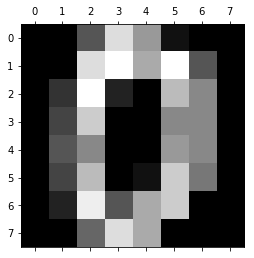

In [335]:
data = load_digits();
X, y = data.data, data.target;
X_train, X_holdout, y_train, y_holdout = train_test_split(data.data, data.target, test_size=0.2,random_state=17);
plt.rcParams['figure.figsize'] = (6,4)
plt.gray();
plt.matshow(data.images[0]);
plt.show();

In [307]:
RANDOM_STATE = 17

In [338]:
tree_entropy = DecisionTreeClassifier(criterion ='entropy',max_depth=5,min_samples_split = 2,random_state=17)
tree_entropy.fit(X_train, y_train)
tree_pred_entropy = tree_entropy.predict(X_holdout)
accuracy_score(y_holdout,tree_pred_entropy)

0.7277777777777777

In [339]:
tree_gini = DecisionTreeClassifier(criterion ='gini',max_depth=5,random_state=17)
tree_gini.fit(X_train, y_train)
tree_pred_gini = tree_gini.predict(X_holdout)
accuracy_score(y_holdout,tree_pred_gini)

0.675

In [340]:
tree_params = {'max_depth': range(3,11),
'criterion': ['gini','entropy']}

In [341]:
tree_grid = GridSearchCV(tree, tree_params,scoring='accuracy',
cv=5, n_jobs=-1,
verbose=True)

In [342]:
tree_grid.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
c:\playground\env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [343]:
tree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 9}

In [344]:
tree_grid.best_score_

0.8684759916492694

In [345]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.8861111111111111

[0.46944444444444444, 0.5666666666666667, 0.675, 0.7861111111111111, 0.8166666666666667, 0.8277777777777777, 0.8361111111111111, 0.8305555555555556, 0.825]
[0.5222222222222223, 0.6361111111111111, 0.7277777777777777, 0.8222222222222222, 0.8805555555555555, 0.8861111111111111, 0.8861111111111111, 0.8861111111111111, 0.8833333333333333]


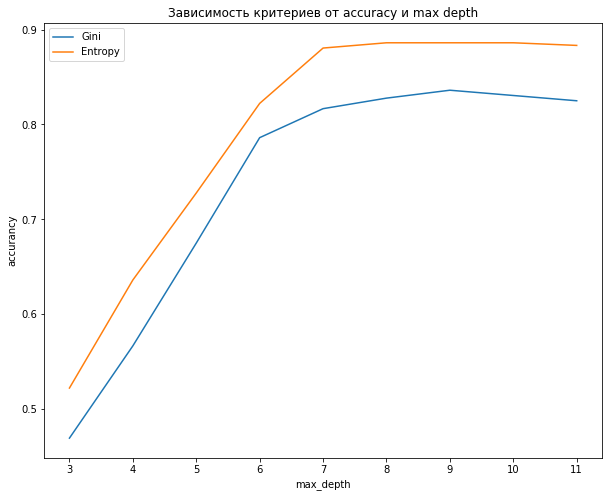

In [353]:
accuracy_gini, accuracy_ent = [], []
M_d = [3,4,5,6,7,8,9,10,11]

for n in M_d:

    DTC_gini = DecisionTreeClassifier(criterion = 'gini',max_depth=n,random_state=17)
    DTC_gini.fit(X_train, y_train)
    DTC_pred_gini = DTC_gini.predict(X_holdout)
    accuracy_gini.append(accuracy_score(y_holdout,DTC_pred_gini).mean())
    
    DTC_ent = DecisionTreeClassifier(criterion = 'entropy',max_depth=n,random_state=17)
    DTC_ent.fit(X_train, y_train)
    DTC_pred_ent = DTC_ent.predict(X_holdout)
    accuracy_ent.append(accuracy_score(y_holdout,DTC_pred_ent).mean())
print(accuracy_gini)
print(accuracy_ent)
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(M_d, accuracy_gini, label='Gini');
plt.plot(M_d, accuracy_ent, label='Entropy')
plt.title('Зависимость критериев от accuracy и max depth')
plt.xlabel('max_depth')
plt.ylabel('accurancy')
plt.legend();

### Ответы:
#### 1. Оптимальное значение ACCURACY для каждого критерия достигается на отрезке [4, 9].                        
#### 2. На отрезке [3, 10] построенные графики не пересекаются.                                          
#### 5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения max_depth на интервале [3, 10].

### Чему равны найденные оптимальные значения параметров max_depth и criterion?
#### 5.max_depth = 9, criterion = 'entropy', accuracy_score = 0.886
#### 6.max_depth = 9, criterion = 'gini', accuracy_score = 0.836


# ГРАФИК НИЖЕ ПОСТРОЕН ПО СКОПИРОВАННОМУ КЛАССУ DecisionTreeClassifier1

[0.46944444444444444, 0.5666666666666667, 0.6722222222222223, 0.7888888888888889, 0.8027777777777778, 0.825, 0.8305555555555556, 0.8333333333333334, 0.8333333333333334]
[0.525, 0.6472222222222223, 0.75, 0.8527777777777777, 0.8916666666666667, 0.8916666666666667, 0.8944444444444445, 0.9, 0.9]


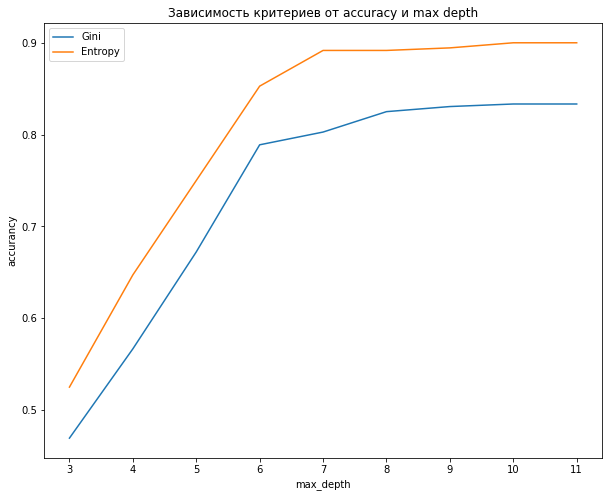

In [355]:
accuracy_gini, accuracy_ent = [], []
M_d = [3,4,5,6,7,8,9,10,11]

for n in M_d:

    DTC_gini = DecisionTreeClassifier1(criterion = 'gini',max_depth=n)
    DTC_gini.fit(X_train, y_train)
    DTC_pred_gini = DTC_gini.predict(X_holdout)
    accuracy_gini.append(accuracy_score(y_holdout,DTC_pred_gini).mean())
    
    DTC_ent = DecisionTreeClassifier1(criterion = 'entropy',max_depth=n)
    DTC_ent.fit(X_train, y_train)
    DTC_pred_ent = DTC_ent.predict(X_holdout)
    accuracy_ent.append(accuracy_score(y_holdout,DTC_pred_ent).mean())
print(accuracy_gini)
print(accuracy_ent)
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(M_d, accuracy_gini, label='Gini');
plt.plot(M_d, accuracy_ent, label='Entropy')
plt.title('Зависимость критериев от accuracy и max depth')
plt.xlabel('max_depth')
plt.ylabel('accurancy')
plt.legend();

# Регрессия

In [327]:
boston = load_boston();
X, y = boston.data, boston.target;
X_train, X_holdout, y_train, y_holdout = train_test_split(boston.data, boston.target, test_size=0.2,random_state=17);

In [329]:
tree_var = DecisionTreeRegressor(criterion='variance',max_depth=5)
tree_var.fit(X_train, y_train)
tree_var_pred = tree_var.predict(X_holdout)
accuracy_score(y_holdout, tree_var_pred)

ValueError: Expected array-like (array or non-string sequence), got None